# Analyse de la performance des modèles entrainés

Différents angles à analyser :
- Existe des classes présentes en nombre mais tout de même mal prédites ?
- A quoi resemble les libellés des classes mal prédites ? Ressemblent-ils à d'autres ? 
- Quelles sont les classes qui sont prédites avec les plus fortes/faibles proba ?
- Est-ce que les erreurs sont faites seulement lorsque la probab associée est faible ou non ?

In [1]:
import sys

import mlflow
import pandas as pd
import yaml

from constants import TEXT_FEATURE, Y
from fasttext_classifier.fasttext_evaluator import FastTextEvaluator
from fasttext_classifier.fasttext_preprocessor import FastTextPreprocessor
from fasttext_classifier.fasttext_wrapper import FastTextWrapper
from utils import get_root_path

import dask.bag as db
import fasttext
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [2]:
preprocessor = FastTextPreprocessor()

In [3]:
df = pd.read_parquet("../data/extraction_sirene_20220602.parquet", engine="pyarrow")

config_path = "config/config_fasttext4.yaml"
with open(get_root_path() / config_path, "r") as stream:
    config = yaml.safe_load(stream)
params = config["params"]
categorical_features = config["categorical_features"]

In [4]:
df_train, df_test, df_gu = preprocessor.preprocess(
    df=df,
    y=Y,
    text_feature=TEXT_FEATURE,
    categorical_features=categorical_features,
)

Pour importer un seul modèle spécifique, il suffit de run les commandes suivantes : 

- export PYTHONPATH="$PWD:$PYTHONPATH"

- export MC_HOST_minio=https://$AWS_ACCESS_KEY_ID:$AWS_SECRET_ACCESS_KEY:$AWS_SESSION_TOKEN@$AWS_S3_ENDPOINT

- mc cp -r minio/projet-ape/mlflow-artifacts/1/33e88b4c4a084622abfb102391e73af0/artifacts/default/artifacts/ models/

In [6]:
model = fasttext.load_model("../models/default.bin")
evaluator = FastTextEvaluator(model)

In [8]:
res_gu = evaluator.get_aggregated_APE_dict(df_gu, Y, TEXT_FEATURE, categorical_features)
#res_test = evaluator.get_aggregated_APE_dict(df_test, Y, TEXT_FEATURE, ["AUTO", "NAT_SICORE"])

100%|██████████| 4/4 [00:00<00:00, 257.17it/s]


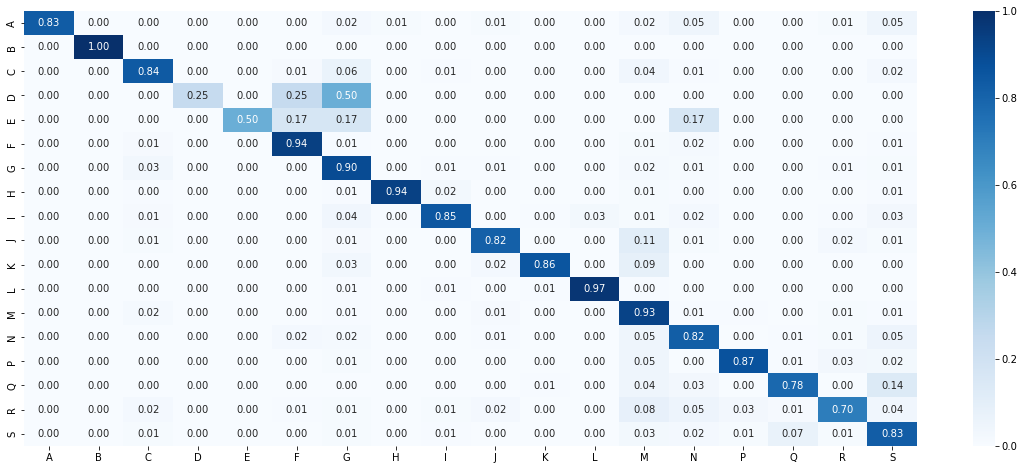

In [9]:
fig = evaluator.plot_matrix(res_gu[1])

In [12]:
#fig = evaluator.plot_matrix(res_test[1])

In [323]:
model = fasttext.load_model("../models/default.bin")
evaluator = FastTextEvaluator(model)

dff = pd.concat([df_gu, df_test.sample(frac = 0.1)])
dff_prepro = evaluator.get_aggregated_APE_dict(dff, Y, TEXT_FEATURE, categorical_features)


100%|██████████| 4/4 [00:00<00:00,  6.99it/s]


In [328]:
dff_prepro = pd.DataFrame(dff_prepro[1])
dff_prepro.set_index('liasseNb', inplace=True)
dff_prepro = dff_prepro.join(dff)   

In [334]:
b = db.from_sequence(dff_prepro['LIB_SICORE'])

wordcount = (b.str.split()       # split into words
             .flatten()                  # chain all words lists
             .frequencies()              # compute occurences
             .topk(100, lambda x: x[1]))  # sort and return top 10 words

list = wordcount.compute() # Run all tasks and return result


In [335]:
ListofWords = sorted(set([word for word,_ in list])) # + [word for word,_ in list_bad]

In [336]:
from tqdm import tqdm

In [337]:
df_word = pd.DataFrame({word :  dff_prepro["ground_truth"][dff_prepro["LIB_SICORE"].str.contains(word)].value_counts(normalize="true").kurtosis() for word in tqdm(ListofWords)}.items(), columns=['Words', 'Kurtosis'])

100%|██████████| 100/100 [00:25<00:00,  4.00it/s]


In [387]:
df_word["Words"][df_word["Kurtosis"]< df_word.Kurtosis.quantile(0.25)].to_list()

['tout',
 'sans',
 'toute',
 'toutes',
 'autres',
 'organisation',
 'activite',
 'realisation',
 'service',
 'services',
 'sous',
 'formation',
 'activites',
 'creation',
 'operations',
 'prestations',
 'agent',
 'decoration',
 'production',
 'entretien',
 'domicile',
 'developpement',
 'electricite',
 'commercial',
 'reparation']

In [339]:
df_word = (df_word
            .dropna()
            .sort_values(by=['Kurtosis'])
            .reset_index(drop=True)
            )


In [375]:
df_word.Kurtosis.quantile(0.25)

7.4185355743914725

In [383]:
df_word.at[25, "Kurtosis"]

7.533529127555488

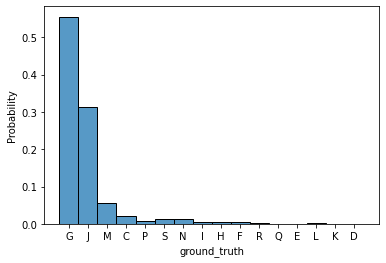

In [385]:
word = df_word.at[26, "Words"]
ax = sns.histplot(x="ground_truth", data=dff_prepro[dff_prepro["LIB_SICORE"].str.contains(word)], stat="probability")

In [318]:
df_word.head(15)

,Words,Kurtosis
0,batis,18.923900
1,renovation,21.600431
2,detail,25.980706
3,activite,28.823271
4,divers,29.280559
5,activites,29.359134
6,infirmiere,30.999380
7,alimentaires,32.188260
8,independant,32.538111
9,realisation,32.923861


## Analyse des classes mal prédites

In [81]:
df_res_gu = pd.DataFrame(res_gu[1])
df_res_gu.set_index('liasseNb', inplace=True)
df_res_gu = df_res_gu.join(df_gu)    

In [168]:
bad_pred = df_res_gu[(df_res_gu["ground_truth"] != df_res_gu["predictions"])] # (df_res_gu["probabilities"] > 0.7) &

In [169]:
b_all = db.from_sequence(df_res_gu['LIB_SICORE'])
b_bad = db.from_sequence(bad_pred['LIB_SICORE'])

wordcount_all = (b_all.str.split()       # split into words
             .flatten()                  # chain all words lists
             .frequencies()              # compute occurences
             .topk(100, lambda x: x[1]))  # sort and return top 10 words

wordcount_bad = (b_bad.str.split()   
             .flatten() 
             .frequencies()  
             .topk(100, lambda x: x[1])) 

list_all = wordcount_all.compute() # Run all tasks and return result
list_bad = wordcount_bad.compute() 

In [275]:
ListofWords = sorted(set([word for word,_ in list_all])) # + [word for word,_ in list_bad]

In [276]:
df_word = pd.DataFrame({word :  df_res_gu["ground_truth"][df_res_gu["LIB_SICORE"].str.contains(word)].value_counts(normalize="true").kurtosis() for word in ListofWords}.items(), columns=['Words', 'Kurtosis'])

In [277]:
df_word = (df_word
            .dropna()
            .sort_values(by=['Kurtosis'])
            .reset_index(drop=True)
            )


In [278]:
df_word.head(15)

,Words,Kurtosis
0,batiment,-1.824982
1,organisation,-0.795277
2,interieur,-0.699985
3,mise,-0.565660
4,etc,-0.494180
5,accessoires,0.285639
6,decoration,0.576386
7,internet,0.613151
8,divers,0.849551
9,tous,0.898726


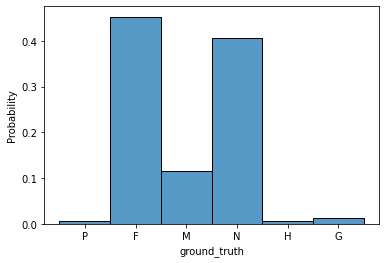

In [279]:
ax = sns.histplot(x="ground_truth", data=df_res_gu[df_res_gu["LIB_SICORE"].str.contains(df_word.at[0, 'Words'])], stat="probability")

Mots les plus fréquents dans le fichiers du guichet unique qui sont également présents dans les plus mal prédits

In [85]:
[word for word,_  in list_all if word in [word_b for word_b,_  in list_bad]]

['conseil',
 'entreprises',
 'vente',
 'creation',
 'domicile',
 'services',
 'produits',
 'travaux',
 'fabrication',
 'service',
 'livraison',
 'entretien',
 'prestations',
 'nettoyage',
 'formation']

Mots les plus fréquents dans les plus mal prédits qui ne sont pas présents dans les plus fréquents dans le fichier du guichet unique

In [86]:
[tup for tup  in list_bad if tup[0] not in [word for word,_  in list_all]]

[('realisation', 11),
 ('montage', 11),
 ('meubles', 10),
 ('decoration', 10),
 ('bricolage', 9),
 ('accompagnement', 9),
 ('design', 8),
 ('petits', 7),
 ('reparation', 7),
 ('divers', 7)]

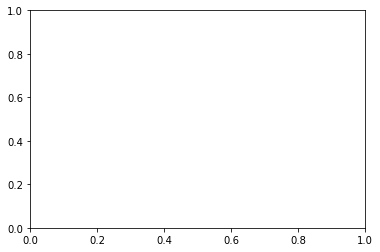

In [319]:
#word = "conseil"
word = "ongulaire"
ax = sns.histplot(x="ground_truth", data=df_res_gu[df_res_gu["LIB_SICORE"].str.contains(word)], stat="probability")

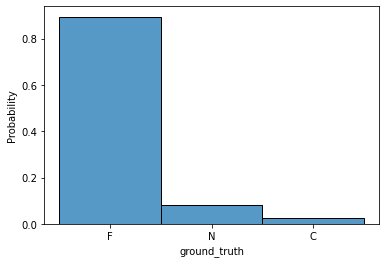

In [196]:
word = "maconnerie"
ax = sns.histplot(x="ground_truth", data=df_res_gu[df_res_gu["LIB_SICORE"].str.contains(word)], stat="probability")

In [201]:
df_res_gu["ground_truth"][df_res_gu["LIB_SICORE"].str.contains(word)].value_counts(normalize="true").kurt()

nan

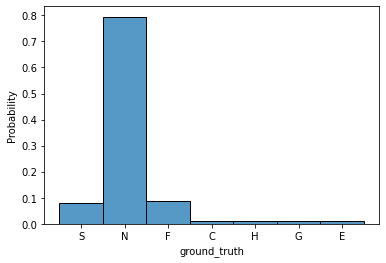

In [160]:
word = "bricolage"
ax = sns.histplot(x="ground_truth", data=df_res_gu[df_res_gu["LIB_SICORE"].str.contains(word)], stat="probability")

In [161]:
df_res_gu["ground_truth"][df_res_gu["LIB_SICORE"].str.contains(word)].value_counts(normalize="true").kurtosis()

6.673929939510314

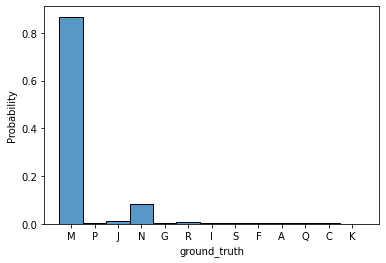

In [155]:
word = "entreprises"
ax = sns.histplot(x="ground_truth", data=df_res_gu[df_res_gu["LIB_SICORE"].str.contains(word)], stat="probability")

In [156]:
df_res_gu["ground_truth"][df_res_gu["LIB_SICORE"].str.contains(word)].value_counts(normalize="true").kurtosis()

12.720332308031425

In [110]:
df_res_gu[df_res_gu["LIB_SICORE"].str.contains(word)]

,ground_truth,predictions,probabilities,APE_NIV5,LIB_SICORE,AUTO,NAT_SICORE
liasseNb,,,,,,,
J00010000461,J,R,0.129413,5912Z,realisation dessins animation,X,NaN
J00010005106,J,J,0.136618,6201Z,realisation site web charte graphique seo prin...,X,NaN
J00010016848,S,S,0.999457,9609Z,realisation tatouages artistiques,X,NaN
J00010007086,J,J,0.160276,5913B,realisation audiovisuelle tournage montage eta...,X,NaN
J00010010288,J,J,0.817585,5911B,realisation clips video captation edition dest...,C,04
...,...,...,...,...,...,...,...
J00010187755,F,F,0.782673,4399C,realisation travaux maconnerie tout genre,M,99
J00010186708,J,M,0.787941,5911B,realisation video secteurs prives publics cadr...,L,NaN
J00010188324,C,C,0.437833,1413Z,realisation vetements objets crochet,M,04


In [92]:
df_naf = pd.read_csv(r"../data/naf_extended.csv", dtype=str)
df_naf.set_index("NIV5", inplace=True, drop=False)

In [149]:
df_naf[df_naf.NIV1 == "S"]

,Unnamed: 0,NIV5,NIV4,NIV3,NIV2,NIV1,LIB_NIV5,LIB_NIV4,LIB_NIV3,LIB_NIV2,LIB_NIV1
NIV5,,,,,,,,,,,
94.11Z,707,94.11Z,94.11,94.1,94,S,Activités des organisations patronales et cons...,Activités des organisations patronales et cons...,"Activités des organisations économiques, patro...",Activités des organisations associatives,Autres activités de services
94.12Z,708,94.12Z,94.12,94.1,94,S,Activités des organisations professionnelles,Activités des organisations professionnelles,"Activités des organisations économiques, patro...",Activités des organisations associatives,Autres activités de services
94.20Z,709,94.20Z,94.20,94.2,94,S,Activités des syndicats de salariés,Activités des syndicats de salariés,Activités des syndicats de salariés,Activités des organisations associatives,Autres activités de services
94.91Z,710,94.91Z,94.91,94.9,94,S,Activités des organisations religieuses,Activités des organisations religieuses,Activités des autres organisations associatives,Activités des organisations associatives,Autres activités de services
94.92Z,711,94.92Z,94.92,94.9,94,S,Activités des organisations politiques,Activités des organisations politiques,Activités des autres organisations associatives,Activités des organisations associatives,Autres activités de services
94.99Z,712,94.99Z,94.99,94.9,94,S,Autres organisations fonctionnant par adhésion...,Activités des organisations associatives n.c.a.,Activités des autres organisations associatives,Activités des organisations associatives,Autres activités de services
95.11Z,713,95.11Z,95.11,95.1,95,S,Réparation d'ordinateurs et d'équipements péri...,Réparation d'ordinateurs et d'équipements péri...,Réparation d'ordinateurs et d'équipements de c...,Réparation d'ordinateurs et de biens personnel...,Autres activités de services
95.12Z,714,95.12Z,95.12,95.1,95,S,Réparation d'équipements de communication,Réparation d'équipements de communication,Réparation d'ordinateurs et d'équipements de c...,Réparation d'ordinateurs et de biens personnel...,Autres activités de services
95.21Z,715,95.21Z,95.21,95.2,95,S,Réparation de produits électroniques grand public,Réparation de produits électroniques grand public,Réparation de biens personnels et domestiques,Réparation d'ordinateurs et de biens personnel...,Autres activités de services


In [37]:
from tqdm import tqdm

In [39]:
try:
    df_naf = pd.read_csv(r"./data/naf_extended.csv", dtype=str)
except FileNotFoundError:
    df_naf = pd.read_csv(r"../data/naf_extended.csv", dtype=str)
df_naf.set_index("NIV5", inplace=True, drop=False)

preds = evaluator.get_preds(df_gu, Y, TEXT_FEATURE, categorical_features)
predicted_classes = [pred[0] for pred in preds]
probs_prediction = [prob[1] for prob in preds]
liasseNb = df_gu.index
res = {
    level: {
        "ground_truth": df_gu[Y].str[:level].to_list(),
        "predictions": [prediction[:level] for prediction in predicted_classes],
        "probabilities": probs_prediction,
        "liasseNb": liasseNb
    }
    for level in tqdm(range(2, 6))
}
res[1] = {
    "ground_truth": [
        df_naf["NIV1"][df_naf["NIV2"] == x].to_list()[0]
        for x in res[2]["ground_truth"]
    ],
    "predictions": [
        df_naf["NIV1"][df_naf["NIV2"] == x].to_list()[0]
        for x in res[2]["predictions"]
    ],
    "probabilities": [
        prob for prob in res[2]["probabilities"]
    ],
    "liasseNb": [
        liasse for liasse in res[2]["liasseNb"]
    ],
}

100%|██████████| 4/4 [00:00<00:00, 288.77it/s]
